### Spectral Clustering: A Novel Approach to Solving the Market Basket Problem

#### Problem Statement

In a competitive grocery retail business where profit margins are roughly 1%-3% [2], optimizing shelf space is key to maximizing profits and improving customer experience. Grocery shelf space optimization involves organizing and strategically allocating shelf space to grocery products in a way that leads to higher sales and increased profits. To achieve this goal requires grocery products placement optimization on limited shelf space, a challenging problem that grocers are constantly faced with. One of the ways grocers optimize product placement and shelf space allocation is identifying high selling products and allocating more space to these products. A better way of maximizing profits is to identify complementary products to these high selling products and placing these complements close to the high selling products. The task of identifying product complements or items bought together is known in the industry as the Market Basket problem and is usually addressed through associative rule mining. Associative rule mining techniques are typically constrained by a lower support bound threshold and generate a set of rules that can be queried to identify which products are more likely to be bought together. The Apriori algorithm [1], one of the major advances in data mining technology [3] is one of the most popular associative rule mining techniques used to analyze customer purchase patterns and generate association rules that can then be interpreted to discover items that are frequently bought together. It is used extensively in the retail industry to identify complementary grocery products, but this technique can become computational expensive for very large datasets if low support threshold is used, and the generated association rules can be challenging to visualize and understand for large dataset. Also, you have a high chance of not discovering some product complements due to the relatively high support bound threshold needed to make the algorithm computationally feasible for large datasets. Other studies have recommended the use of optimization models to mine association rules, but this requires expertise, face challenges with large datasets and can also be computationally expensive. This project aims to address most of these shortcomings by treating the market basket problem as a community detection problem where grocery items are represented in the form of a network graph and spectral clustering used to identify communities of grocery items that are frequently bought together. Leveraging effective graph visualization tools, one can easily identify the food communities or clusters spectral clustering finds and communicate these results or findings more effectively. In addition to using these results to optimize product placement on shelves, the clusters found by spectral clustering can also form the basis of a recommender system for grocers with online presence.

#### Methodology 

In this project, the market basket problem was cast as a network graph problem where the nodes of the graph represent grocery items, and the edges represent connections between grocery items. Connections only exist between grocery items if those grocery items have been bought together on a purchase transaction. For this project, the graph built was undirected and unweighted and the adjacency matrix was used as the similarity matrix.

To build the graph, node and edge lists were created from the cleaned combined groceries dataset. To facilitate easy visualization of the spectral clustering results, each grocery item was mapped to a numeric value and based on this mapping the node list was created with each numeric node representing a unique grocery item in the combined dataset. Using the numeric mapping, an edges list was created where each pair of numeric nodes in the list represents co-occurrence of a pair of grocery items on a purchase receipt. 

Using the created edge list and the NetworkX python package, a normalized Laplacian matrix was created. Performing eigen-decomposition on the normalized graph Laplacian, the k smallest eigenvectors were selected and the K-means algorithm run on the selected eigenvectors to identify clusters of grocery items frequently bought together. NetworkX was then used to display the results of the spectral clustering and visualize the grocery communities found by the spectral clustering algorithm. To determine the optimum number of clusters to use for the spectral clustering, the downstream end use of the results was used to tune k. Since each grocery store has limited shelf space, there is a limit to how many items can be placed together so k was tuned to ensure that the maximum number of items in each cluster does not exceed 10. The code below shows how this was implemented in Python.

In [3]:
#load dataset
import pandas as pd
grocery = pd.read_csv("grocery_final.csv")
grocery_upd = grocery.iloc[:,1:]

#create node list
unique_values = grocery_upd.values.flatten()
unique_values = pd.Series(unique_values).unique()

#convert node list to node list dataframe and removing missing values
grocer_nodelist = pd.DataFrame(unique_values).dropna()



#create edge_list
#melt the dataframe
edge_list = grocery_upd.melt(id_vars = grocery_upd.columns[0], value_name = "Target")
edge_list = edge_list[[grocery_upd.columns[0], "Target"]].dropna()
edge_list.columns =["Source", "Target"]


#map each grocery item to a node id
node_list = pd.read_csv("node_list.csv", header = None)

node_map = dict(zip(node_list.iloc[:,1], node_list.iloc[:,0]))
print(node_map)


#Update edge_list with numbers

edge_list["Source_num"] = edge_list["Source"].map(node_map)
edge_list["Target_num"] = edge_list["Target"].map(node_map)



#Create unweighted edge list
edge_listwt = edge_list.groupby(["Source_num","Target_num"]).size().reset_index(name = "Weight")

edge_listwtcp = edge_listwt.copy()
edge_listwtcp["Weight"] = 1


{'citrus fruit': 1, 'semi-finished bread': 2, 'margarine': 3, 'ready soups': 4, 'tropical fruit': 5, 'yogurt': 6, 'coffee': 7, 'pip fruit': 8, 'cream cheese': 9, 'meat spreads': 10, 'other vegetables': 11, 'whole milk': 12, 'condensed milk': 13, 'long life bakery product': 14, 'butter': 15, 'rice': 16, 'abrasive cleaner': 17, 'UHT-milk': 18, 'rolls/buns': 19, 'bottled beer': 20, 'liquor (appetizer)': 21, 'cereals': 22, 'white bread': 23, 'bottled water': 24, 'chocolate': 25, 'curd': 26, 'flour': 27, 'dishes': 28, 'frankfurter': 29, 'soda': 30, 'chicken': 31, 'sugar': 32, 'fruit/vegetable juice': 33, 'newspapers': 34, 'butter milk': 35, 'pastry': 36, 'processed cheese': 37, 'detergent': 38, 'root vegetables': 39, 'frozen dessert': 40, 'sweet spreads': 41, 'salty snack': 42, 'waffles': 43, 'candy': 44, 'bathroom cleaner': 45, 'canned beer': 46, 'sausage': 47, 'brown bread': 48, 'shopping bags': 49, 'beverages': 50, 'specialty bar': 51, 'hamburger meat': 52, 'spices': 53, 'hygiene article

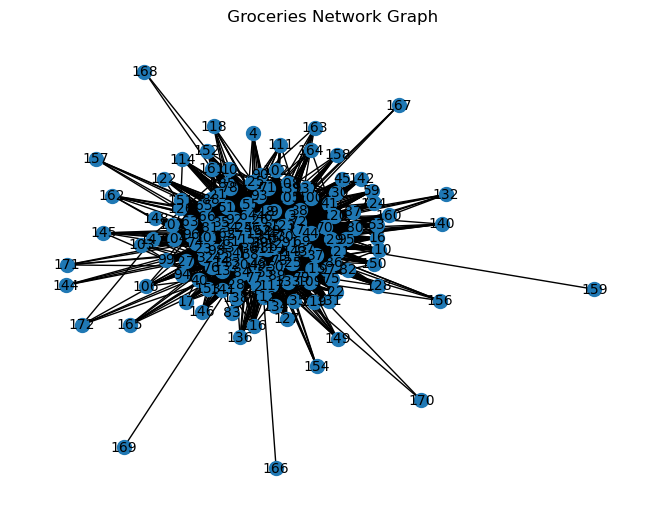

In [5]:
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt


#Create Network Graph
G = nx.from_pandas_edgelist(edge_listwtcp, source = "Source_num", target = "Target_num", edge_attr = "Weight", create_using = nx.Graph())
node_pos = nx.spring_layout(G)
nx.draw(G,node_pos, with_labels = True, node_size = 100, font_size = 10)
plt.title(" Groceries Network Graph")
plt.show()



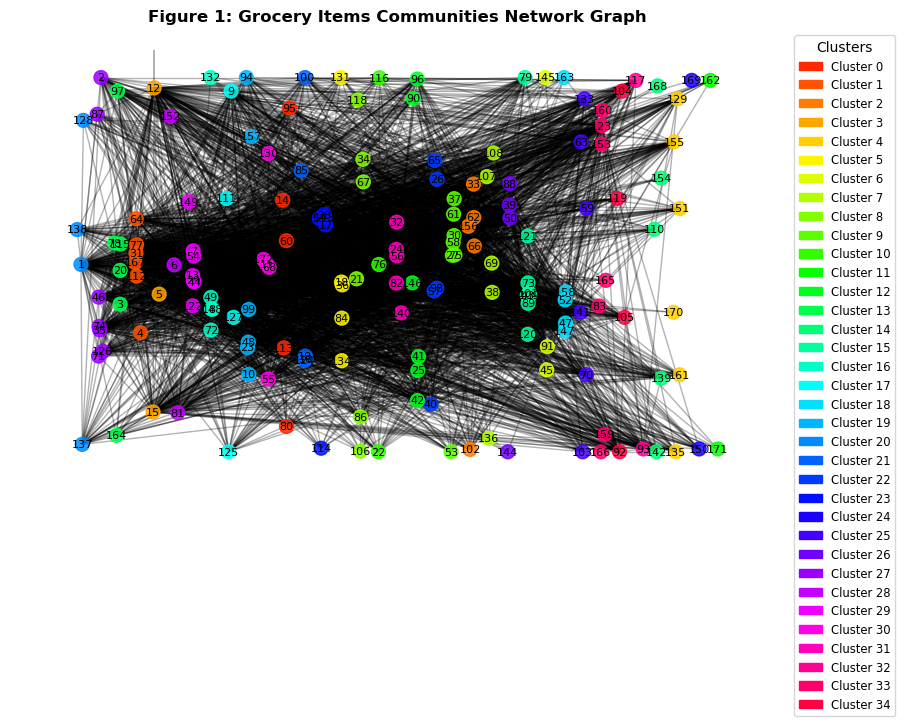

In [13]:
#Compute normalized Graph Laplacian


L = nx.normalized_laplacian_matrix(G, weight = "Weight").toarray()

#Select appropriate k so that the maximum number of grocery items in a cluster is 10
k = 35

#calculate the eigen values and eigenvectors of graph laplacian and select the k eigenvectors corresponding to the k smallest eigenvalues
u, v = np.linalg.eig(L)
idx = u.argsort()
v = v[:, idx]
smallest_v = v[:, 0:k].real


#normalize eigenvectors
smallest_v_norm = normalize(smallest_v)

#Perform KMeans Clustering on selected eigenvectors
kmeans = KMeans(n_clusters=k, random_state = 0)
labels = kmeans.fit_predict(smallest_v_norm)


#Attach labels to nodes
node_labels = dict(zip(node_list.iloc[:,0],labels))


# Generate grocery items cluster Network graph

from collections import defaultdict
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.cm as cm
def cluster_grouped_layout(G, labels, spacing = 5):
    clusters = defaultdict(list)
    for node, label in labels.items():
        clusters[label].append(node)
    
    pos = {}
    for i, (cluster_id, nodes) in enumerate(clusters.items()):
        subgraph = G.subgraph(nodes)
        sub_pos = nx.spring_layout(subgraph, seed = 42)
        offset = np.array([i * spacing, 0])
        for node in subgraph.nodes():
            pos[node] = sub_pos[node] + offset

    return pos

pos = cluster_grouped_layout(G, node_labels)

import seaborn as sns
unique_clusters = sorted(set(node_labels.values()))
palette = sns.color_palette("hsv",len(unique_clusters))
cluster_color_map = {cid:palette[i] for i, cid in enumerate(unique_clusters)}
node_colors = [cluster_color_map[node_labels[node]] for node in G.nodes()]
plt.figure(figsize = (10,6))
nx.draw_networkx_nodes(G, pos, node_color = node_colors, node_size = 100, alpha = 0.85)
nx.draw_networkx_edges(G, pos, alpha = 0.3)
nx.draw_networkx_labels(G, pos, font_size = 8)
handles = [ mpatches.Patch(color = cluster_color_map[cid], label = f"Cluster {cid}")
           for cid in unique_clusters]
plt.legend(handles = handles, title = "Clusters",bbox_to_anchor= (1.15,1.0), loc = "upper right", fontsize = "small")
plt.axis("off")
plt.title("Figure 1: Grocery Items Communities Network Graph", fontweight = "bold")
plt.show()

### Analysis of Results

Analysis of the spectral clustering output showed multiple clusters with logical grouping of grocery items that you will expect shoppers to buy together. Two of such clusters are Cluster 3 and Cluster 18 in Figure 1. Nodes 12,5 and 15 in Cluster 3 represent whole milk, tropical fruit and butter respectively. This can easily be a baking basket of items thus making it a logical set of items to be grouped together. Nodes 163,158,52,47 and 147 are in Cluster 18 and represent frozen fruits, specialty vegetables, hamburger meat, sausage and kitchen towels. This comes across as a refrigerated food items basket with the kitchen towel acting as a cleanup item for events like backyard barbecue involving sausage and hamburger meat. Other clusters showed a mix of grocery basket items, one of such clusters is Cluster 4. Cluster 4 consist of nodes 129,155,151,170,161 and 135 corresponding to pet care, organic sausage, jam, roll products, tidbits and vinegar. This basket can be broken into two mini- baskets, one consisting of pet care and vinegar and the other, the remaining 4 grocery items. One can easily see why someone with pets will buy vinegar to address pet odors and the other 4 grocery items in Cluster 4 can easily fit into a sandwich picnic basket. Although most of the clusters(communities) detected by the spectral clustering either had one cohesive grouping like Cluster 3 or mix of groceries groupings like Cluster 4, a few clusters had groupings that are not so cohesive, an example of such is Cluster 8 which is made up of nodes 118,34,67,21,86 and 106. These nodes represent makeup remover, newspapers, cat food, liquor, flower seeds and honey and does not seem to have much in common. Further investigation of the original dataset revealed that pairs of items in this grouping occurred together on different purchase orders but not all in the same purchase order. One possible explanation for why spectral clustering created such groupings could be that these items may be one off shopping items purchased to supplement items left off a bigger shopping list which will explain why they all occur on different purchase orders, we will expect that one-time off purchases like this might be challenging for the spectral clustering algorithm to group cohesively.

Overall, our results showed that spectral clustering was successful in detecting cohesive communities of grocery items frequently bought together from our grocery dataset. Based on the spectral clustering output, grocers can easily filter the results to identify the clusters containing their highest selling products and then subsequently identify the complements from these clusters that should be place beside these high selling products. In addition, for grocers with online presence, these clusters’ components can form the basis for a recommender system that can help boost their online sales.

### Evaluation

Since spectral clustering is an unsupervised learning algorithm, the evaluation of this project’s results was focused on assessing the performance and scalability of the spectral clustering algorithm on our groceries dataset.

**Scalability Evaluation**

Experiments were run to assess the spectral clustering algorithm’s capability to handle increasing dataset sizes by monitoring run time as the dataset size increases. Table 1 shows the results of this experiment.



<center><b>Table 1: Grocery Dataset Spectral Clustering Scalability Test</b></center>

| Number of Nodes | Number of Edges | Wall Clock Time (sec) |
|:---------:|:--------:|:--------:|
|  173   |  4389   | 0.65   | 
| 700  |  7146   |  3.52   |
|  34231   | 102174  | >>8525   |


Results showed that for small to mid-size datasets, spectral clustering was computationally efficient, but the algorithm struggled when the dataset becomes large. This observation is not surprising since this is a known issue that spectral clustering is not scalable in its traditional form. For such situation, it is recommended to explore the ultra-scalable spectral clustering algorithm proposed by Huang et al [4] in their 2020 paper.

#### Performance Evaluation

Silhouette and Calinski- Harabasz scores were used to measure how well the spectral clustering algorithm performed with respect to forming well separated clusters. Since this performance evaluation was focused on clustering efficiency and not how many items can be reasonably placed together in a grocery shelf, smaller values of k were used for this performance evaluation. The evaluation results are discussed below.

**Silhouette score**: This performance metric measures how well each data point is assigned to its cluster compared to other clusters. This measure ranges from -1 to 1, with scores close to +1 indicating highly dense well separated clustering and negative values generally indicating that data points have been assigned to the wrong cluster. Score values close to zero is suggestive of overlapping clusters. The code below shows the results for when k = 2 and Table 2 summarizes the Silhouette scores obtained for different k clusters.

In [57]:
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(smallest_v_norm, labels)
sil_score

0.7011466906259799

<center><b>Table 2: Grocery Dataset Spectral Clustering Silhouette Score</b></center>

| Number of Clusters | Silhouette Score |
|:---------:|:--------:|
|  2   |  0.701   | 
| 3  |  0.453   |  
| 4   | 0.330 | 
|  5   | 0.200  | 

The results displayed in Table 2 shows that for this dataset, we can achieve well defined separated clusters. The drop in silhouette score as we increase the number of clusters is not surprising for spectral clustering since our objective is to find nodes that are similar via connections but not necessarily densely co-located spatially which will be the case for our grocery dataset, thus we will expect less dense co-location of nodes as we increase the number of clusters.

**Calinski- Harabasz score**: This is the ratio of the sum of between cluster dispersion and of within cluster dispersion for all clusters. Higher values indicate a model with better defined clusters. The code below shows the output for 2 clusters and Table 3 shows the Calinski-Harabasz scores obtained for different k clusters.

In [63]:
from sklearn.metrics import calinski_harabasz_score
cal_score = calinski_harabasz_score(smallest_v_norm, labels)
cal_score

711.8023281974536

<center><b>Table 3: Grocery Dataset Spectral Clustering Calinski-Harabasz Score</b></center>

| Number of Clusters | Silhouette Score |
|:---------:|:--------:|
|  2   |  712   | 
| 3  |  170   |  
| 4   | 84 | 
|  5   | 43  |

Not surprising, the Calinski-Harabasz scores also follow the same pattern as the Silhouette score as the number of clusters increases and the same logic used to explain this pattern for the silhouette score applies here too.

Based on the results of our performance evaluation, we can conclude that there are no major performance concerns for the spectral clustering done on our grocery dataset.

#### Conclusions 

In this project, we presented a novel approach to solving the market basket problem and helping grocers optimize product placement on their limited shelf space. My approach involves treating the market basket problem as a community detection problem where grocery items are represented in the form of a network graph where the nodes of the graph represent grocery items, and the edges represent connections between grocery items purchased together. Spectral clustering is then used to identify communities of grocery items that are frequently bought together.

Analysis of our spectral clustering results showed that although the algorithm was able to detect logical and cohesive communities of grocery items that we expect to be bought together, we did observe some anomalies where grocery items grouped together did not have much in common.

Evaluation of the spectral clustering algorithm on our grocery dataset shown that spectral clustering is computationally efficient for small to midsize datasets but not so much for large dataset. For huge dataset, it is recommended to explore the use of the ultra-scalable spectral clustering algorithm. Although the performance evaluation done showed that the spectral clustering algorithm was able to generate well defined separated clusters for our dataset, it is recommended that visual inspection of the spectral clustering results is always done for cohesiveness in clusters groupings since this is essentially an unsupervised learning algorithm.

Future extension of the approach presented in this project could include using a weighted graph where the weight of each edge could represent the frequency at which a particular pair of grocery items are bought together. This approach could result in more cohesive groupings and possibly address some of the anomalous groupings detected by our unweighted graph spectral clustering algorithm. Most of the purchase receipts used to build our dataset had few grocery items per receipt, incorporating more purchase orders with more grocery items per receipt in our grocery dataset will result in a better and richer dataset that we expect to give better spectral clustering results.

In conclusion, this project showed that spectral clustering can successfully solve the market basket problem and detect communities of grocery items frequently bought together. It is my expectation that the grocery items clusters identified by the spectral clustering algorithm will go beyond providing valuable insights on what grocery items should be placed next to each other but also form the basis for a recommender system for grocers with online presence.

References

[1] Agrawal, R., Imieliński, T., & Swami, A. (1993). Mining association rules between sets of items in large databases. SIGMOD Record, 22(2), 207–216. https://doi.org/10.1145/170036.170072

[2] https://www.grocerydive.com/news/grocery-industry-profit-margins-fall-to-pre-pandemic-levels-fmi/720517/

[3] https://hastie.su.domains/ElemStatLearn/

[4] Huang, D., Wang, C.-D., Wu, J.-S., Lai, J.-H., & Kwoh, C.-K. (2020). Ultra-Scalable Spectral Clustering and Ensemble Clustering. IEEE Transactions on Knowledge and Data Engineering, 32(6), 1212–1226. https://doi.org/10.1109/TKDE.2019.2903410
